# Thinkful Data Science Prep Course Capstone Project: 
# Occam Video Solutions Sales Data

**Teresa O'Neill**

**September, 2017**

## Overview

Occam Video Solutions is a small software company specializing in forensic video analysis. Currently in its second year of operations, Occam Video Solutions is cultivating a law enforcement customer base for its flagship product, iNPUT-ACE, an application that streamlines the analysis of video evidence by allowing investigators and technicians to manage video in hundreds of proprietary digital formats. Occam Video Solutions also provides training and technical support for iNPUT-ACE. 

Occam Video Solutions' certified forensic video analysts offer training workshops and technical presentations throughout the U.S. and internationally under the auspices of professional organizations like the Law Enforcement Video Association. Workshops and presentations support iNPUT-ACE marketing campaigns by including demonstrations of the software's functionality. Ideally, every agency that purchases an iNPUT-ACE license should also purchase a seat at an iNPUT-ACE Hands-On Training workshop, and vice versa. 

The purpose of this report is to analyze the sales pipeline for Occam Video Solutions products. It includes a description of the customer base, a summary of sales to date, and an analysis of purchasing behavior of different law enforcement agencies. The report addresses three primary analytic questions:

**1. What is the makeup of Occam Video Solutions' current customer base?**

**2. How do Occam different products move through the sales pipeline?**

**3. How do demographic, marketing, and product-related factors affect purchasing behavior?**


The data examined in this report come from two sources:

- SalesForce reports on Occam Video Solutions' customer base, sales opportunities, and marketing campaigns (technical presentations and trainings).
- Results of a national survey by the Bureau of Justice Statistics (U.S. Department of Justice, Bureau of Justice Statistics, 2013) on the demographics and expenditures of a sample of local, county, and state law enforcement agencies. 


In [665]:
#preamble
import numpy as np
import pylab
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
%matplotlib inline
import datetime
from datetime import date
#import statsmodels.api as sm
#from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("Set2", 10)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import time

In [257]:
#import the data
campaigns = pd.read_csv('campaigns.csv')
contacts = pd.read_csv('contacts.csv')
opportunities = pd.read_csv('opportunities.csv')
bjs = pd.read_csv('bjs_data.csv', na_values=['#NULL!'])

## 1. The Customer Base

The first component of this analysis concerns the makeup of the customer base. We would like the following information about Occam Video Solutions' customers:

- How many agencies are represented in the contacts list, and how many contacts does Occam Video Solutions have at each agency?
- Where are the customers located?
- What types of agencies are represented (e.g., local law enforcement, state police, federal agencies), and how is the customer base distributed across these types of agencies?
- How big is each agency, in terms of personnel and operating budget? 

To answer these questions, we will examine the contacts report from SalesForce, which includes a list of the individual contacts logged in SalesForce, along with the corresponding agency. Data from the Bureau of Justice Statistics survey provides supplementary information about the demographics and expenditures of a *subset* of the law enforcement agencies in the contacts list. 

### *Summary of contacts and agencies*

Occam Video Solutions' current customer base includes 3,583 contacts across 1,772 agencies, with an average of 2 contacts per agency. At all but three agencies (Houston Police Department, Metropolitan Nashville Police Department, and Seattle Police Department), Occam has fewer than 20 contacts. The histogram below shows how many contacts Occam has at each agency in its customer base.  

In [276]:
contacts_len = len(contacts)

#Count how many contacts are listed for each agency.
contacts['Contacts per Agency'] = contacts.groupby('Agency Name')['Agency Name'].transform('count')

#Create a dataframe with one entry per agency.
agencies = contacts.drop_duplicates(subset='Agency Name', keep="first")
agencies_len = len(agencies)

print('contacts: {}; \nagencies: {}'.format(contacts_len, agencies_len))
print('\nAgencies with at least 25 contacts:')
print(agencies.loc[agencies['Contacts per Agency']>20, ['Agency Name','Contacts per Agency']])

contacts: 3583; 
agencies: 1772

Agencies with at least 25 contacts:
                                   Agency Name  Contacts per Agency
1341                 Houston Police Department                   43
1900  Metropolitan Nashville Police Department                   41
2898                 Seattle Police Department                   28


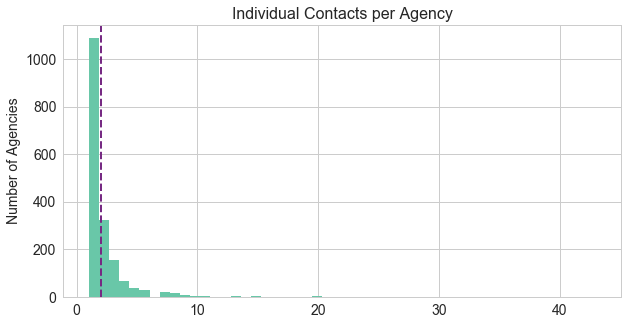

count   $1,772
mean        $2
std         $2
min         $1
25%         $1
50%         $1
75%         $2
max        $43
Name: Contacts per Agency, dtype: float64

In [350]:
#Plot a histogram of contacts per agency.

plt.figure(figsize=(10, 5))
ax = agencies['Contacts per Agency'].plot(kind='hist', bins=50, fontsize=14, color='#69c7a8')
ax.set_title('Individual Contacts per Agency', fontsize=16)
plt.axvline(contacts_per_agency.mean(), color='#762a83', linestyle='dashed', linewidth=2)
plt.ylabel('Number of Agencies', fontsize=14)
plt.show()

agencies['Contacts per Agency'].describe()

### *Locations of customers*

The customer base includes agencies in 70 different countries. Of these agencies, 88.9% are located in the United States, 3.4% are located in Canada, and 1.4% are located in the United Kingdom. 

countries: 70
Mailing Country
New Zealand       0.28
Australia         0.40
United Kingdom    1.41
Canada            3.44
United States    88.94
dtype: float64


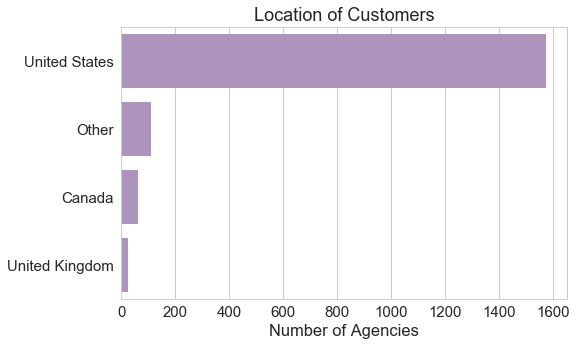

In [282]:

#Check the top five countries represented in the contacts list.
countries_len = agencies['Mailing Country'].nunique()
print('countries: {}'.format(countries_len))
country_percent = agencies.groupby('Mailing Country').size().transform(lambda x: x/sum(x) *100)
country_percent.sort_values(inplace=True, ascending=True)
print(country_percent)[-5:]

#Create a new variable to track the top 3 countries in the contacts list, and plot. 
country = agencies['Mailing Country'].apply(lambda x: 'Other' if (x !='United States' and x!='Canada' and x!='United Kingdom') else x)

#country.value_counts().plot(kind='barh', fontsize=14)
#plt.ylabel('')
#plt.title('Location of Customers', fontsize=16)
#plt.ylabel('')
#plt.xlabel('Number of Agencies', fontsize=14)
#plt.show()

plt.figure(figsize=(8, 5))
order = ['United States', 'Other', 'Canada', 'United Kingdom']
ax1 = sns.countplot(y=country, data=agencies, color="#af8dc3", order=order)
ax1.set(xlabel='Number of Agencies', ylabel='', title='Location of Customers')

### *Types of agencies in customer base*

Now let us get a sense for the types of agencies in the customer base and the jurisdictions they represent.

In [285]:
#Create a variable to categorize the types of agencies in the agencies list.
agencies['type'] = 'Other'
agencies.loc[(agencies['Agency Name'].str.contains('Military')), ['type']] = 'Military'
agencies.loc[(agencies['Agency Name'].str.contains('Air Force')), ['type']] = 'Military'
agencies.loc[(agencies['Agency Name'].str.contains('Armed Forces')), ['type']] = 'Military'
agencies.loc[(agencies['Agency Name'].str.contains('Marine Corps')), ['type']] = 'Military'
agencies.loc[(agencies['Agency Name'].str.contains('Army')), ['type']] = 'Military'
agencies.loc[(agencies['Agency Name'].str.contains('Navy')), ['type']] = 'Military'
agencies.loc[(agencies['Agency Name'].str.contains('Fire ')), ['type']] = 'Fire'
agencies.loc[(agencies['Agency Name'].str.contains('Police Department')), ['type']] = 'Police'
agencies.loc[(agencies['Agency Name'].str.contains('of Police')), ['type']] = 'Police'
agencies.loc[(agencies['Agency Name'].str.contains('Police Service')), ['type']] = 'Police'
agencies.loc[(agencies['Agency Name'].str.contains('University')), ['type']] = 'Police'
agencies.loc[(agencies['Agency Name'].str.contains('County Police')), ['type']] = 'Police'
agencies.loc[(agencies['Agency Name'].str.contains('Department of Public Safety')), ['type']] = 'Public Safety'
agencies.loc[(agencies['Agency Name'].str.contains('Sheriff')), ['type']] = 'Sheriff'
agencies.loc[(agencies['Agency Name'].str.contains('Constab')), ['type']] = 'Police'
agencies.loc[(agencies['Agency Name'].str.contains('District Attorney')), ['type']] = 'Prosecutor'
agencies.loc[(agencies['Agency Name'].str.contains('Prosecutor')), ['type']] = 'Prosecutor'
agencies.loc[(agencies['Agency Name'].str.contains('LLC')), ['type']] = 'Private Attorney'
agencies.loc[(agencies['Agency Name'].str.contains('State Police')), ['type']] = 'State Police'
agencies.loc[(agencies['Agency Name'].str.contains('State Trooper')), ['type']] = 'State Police'
agencies.loc[(agencies['Agency Name'].str.contains('State Patrol')), ['type']] = 'State Police'
agencies.loc[(agencies['Agency Name'].str.contains('Federal')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('National')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('United States')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('US Customs and Border Protection')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('US Department of Commerce')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('US Marshals Service')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('Bureau of Alcohol, Tobacco, Firearms & Explosives')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('Department of Homeland Security')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('Department of Justice')), ['type']] = 'Prosecutor'
agencies.loc[(agencies['Agency Name'].str.contains('Drug Enforcement Administration')), ['type']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('FBI')), ['type']] = 'Federal'

#Create a variable to categorize the jurisdictions of agencies in the agencies list.
agencies['jurisdiction'] = 'Unknown/Other'
agencies.loc[(agencies['type'].str.contains('Military')), ['jurisdiction']] = 'Military'
agencies.loc[(agencies['Agency Name'].str.contains('City of')), ['jurisdiction']] = 'Local'
agencies.loc[(agencies['Agency Name'].str.contains('Police Department')), ['jurisdiction']] = 'Local'
agencies.loc[(agencies['Agency Name'].str.contains('Police Service')), ['jurisdiction']] = 'Local'
agencies.loc[(agencies['type'].str.contains('Fire')), ['jurisdiction']] = 'Local'
agencies.loc[(agencies['Agency Name'].str.contains('Sheriff')), ['jurisdiction']] = 'County'
agencies.loc[(agencies['Agency Name'].str.contains('County')), ['jurisdiction']] = 'County'
agencies.loc[(agencies['Agency Name'].str.contains('Constabulary')), ['jurisdiction']] = 'County'
agencies.loc[(agencies['Agency Name'].str.contains('District Attorney')), ['jurisdiction']] = 'County'
agencies.loc[(agencies['type'].str.contains('State Police')), ['jurisdiction']] = 'State/provincial'
agencies.loc[(agencies['Agency Name'].str.contains('Provincial')), ['jurisdiction']] = 'State/provincial'
agencies.loc[(agencies['Agency Name'].str.contains('Federal') & agencies['Mailing Country'].str.contains('United States')), ['jurisdiction']] = 'Federal/National'
#agencies.loc[(agencies['Agency Name'].str.contains('Federal') & agencies['Mailing Country'].str.contains('Canada')), ['jurisdiction']] = 'Federal (Can)'
agencies.loc[(agencies['Agency Name'].str.contains('United States')), ['jurisdiction']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('Bureau of Alcohol, Tobacco, Firearms & Explosives')), ['jurisdiction']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('Department of Homeland Security')), ['jurisdiction']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('US Department of Justice')), ['jurisdiction']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('Drug Enforcement Administration')), ['jurisdiction']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('FBI')), ['jurisdiction']] = 'Federal'
agencies.loc[(agencies['Agency Name'].str.contains('University')), ['jurisdiction']] = 'Campus'
agencies.loc[(agencies['type'].str.contains('Federal')), ['jurisdiction']] = 'Federal'


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [287]:
#Determine the top three types of agencies.
type_percents = agencies.groupby('type').size().transform(lambda x: x/sum(x) *100)
type_percents.sort_values(inplace=True, ascending=True)
print(type_percents)[:3]

type
Military            0.34
Fire                0.51
Private Attorney    1.13
Public Safety       1.13
State Police        1.41
Prosecutor          2.99
Federal             4.06
Sheriff            13.09
Other              21.84
Police             53.50
dtype: float64


Police agencies account for the largest proportion (53.5%) of the customer base. The high preponderance of agencies classified as "Other" (21.8%) may be due to naming idiosyncrasies  and international agencies, which resist automatic classification. The bar chart below depicts the number of each type of agency in the customer base. 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


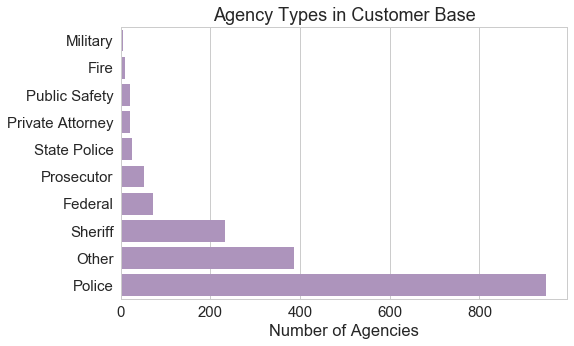

In [288]:
#Plot the frequencies of the different agency types in the customer base.

#agencies['type'].value_counts().plot(kind='barh',fontsize=14)
#plt.title('Agency Types in Customer Base', fontsize=16)
#plt.ylabel('')
#plt.xlabel('Number of Agencies', fontsize=14)
#plt.show()

agencies['typecount'] = agencies.groupby('type')['type'].transform('count')
agencies.sort_values(by='typecount', ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
ax = sns.countplot(y='type', data=agencies, color="#af8dc3")
ax.set(xlabel='Number of Agencies', ylabel='', title='Agency Types in Customer Base')

Now that we know the types of agencies represented in the customer base, it is also useful to note the jurisdictions they serve. In the plot below, "Unknown/Other" includes private agencies. Most of Occam's customers operate at the local and county levels.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


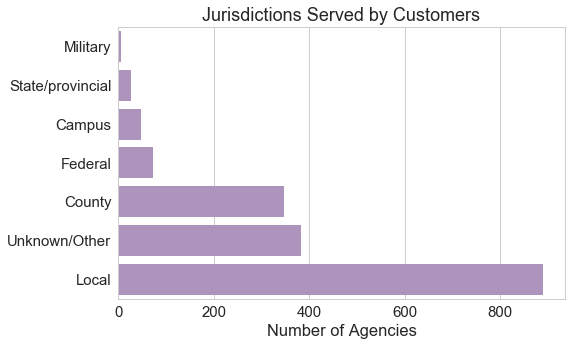

In [289]:
#Plot the frequencies of the different jurisdictions served by agencies in the customer base.

#agencies['jurisdiction'].value_counts().plot(kind='barh', fontsize=14)
#plt.title('Jurisdictions Served by Customer Agencies', fontsize=16)
#plt.show()

agencies['jurisdictioncount'] = agencies.groupby('jurisdiction')['jurisdiction'].transform('count')
agencies.sort_values(by='jurisdictioncount', ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
ax = sns.countplot(y='jurisdiction', data=agencies, color="#af8dc3")
ax.set(xlabel='Number of Agencies', ylabel='', title='Jurisdictions Served by Customers')

### *Data from the Bureau of Justice Statistics Survey*

While Occam Video Solutions' contacts list includes only basic contact information, a 2013 survey administered by the Bureau of Justice Statistics (BJS) offers additional insight into some of the agencies in the customer base. BJS gathered data from 2,826 local, county, and state law enforcement agencies in the United States. The survey consisted of 362 questions about agency demographics, jurisdiction, and expenditures. 

Five hundred seventy-five (575) of the agencies sampled by the survey are also represented in the Occam Video Solutions customer base. Unfortunately, comparable data are not available for the other 1,197 agencies in the customer base, including international agencies, federal agencies, attorneys, and many others. Focusing on the subset of Occam's customer base for which data are available, we can examine the size and budget of the agencies as a window into their potential needs and purchasing power. 

First, we will consider the size of each agency, in terms of full-time sworn personnel. As the histogram on the left below shows, most of the agencies in the sample are rather small: half have fewer than 161 full-time sworn officers. This is consistent with the many small municipalities and counties in the United States. The distribution of agency personnel size is skewed by the extremely large size of the police departments in major metropolitan areas like New York City and Chicago. We get a clearer sense for the distribution of agency personnel size when we examine only the bottom 75% of the data, which is to the left of the dashed line in the left-side plot. The plot to the right shows only the data to the left of the dashed line.

In [290]:
#Create a dataframe with the subset of the BJS sample that are also in Occam's contact list.
print(len(bjs.columns))
print(len(bjs.index))
bjs_sub = bjs.dropna(subset=['AGENCY ID'])
print(len(bjs_sub))
print(len(agencies) - len(bjs_sub))
bjs_sub['Name'] = bjs_sub['BJS_AGENCYNAME'].str.title()

362
2826
575
1197


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


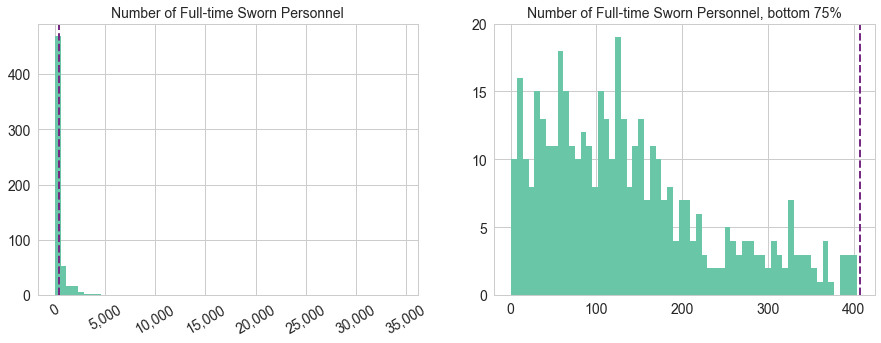

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count      575
mean       529
std      1,758
min          1
25%         79
50%        161
75%        407
max     34,454
Name: FTSWORN, dtype: float64

In [351]:
pd.options.display.float_format = '{:,.0f}'.format

#Define a dataset taking only the bottom 75% of agency sizes.
bjs_sub1 = bjs_sub[bjs_sub['FTSWORN']<[bjs_sub['FTSWORN'].quantile(.75)]]

#Plot histograms of agency sizes.
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
ax=bjs_sub['FTSWORN'].plot(kind='hist', fontsize=14, bins=60, color='#69c7a8')
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
plt.axvline(bjs_sub['FTSWORN'].quantile(.75), color='#762a83', linestyle='dashed', linewidth=2)
plt.ylabel('')
plt.title('Number of Full-time Sworn Personnel', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=30)

plt.subplot(1, 2, 2)
ax=bjs_sub1['FTSWORN'].plot(kind='hist', fontsize=14, bins=60, color='#69c7a8')
plt.ylabel('')
plt.title('Number of Full-time Sworn Personnel, bottom 75%', fontsize=14)
plt.xlabel('')
plt.axvline(bjs_sub['FTSWORN'].quantile(.75), color='#762a83', linestyle='dashed', linewidth=2)
plt.yticks([0,5,10,15,20,])
#plt.xticks(rotation=30)

plt.show()

bjs_sub.sort_values('FTSWORN', inplace=True, ascending=False)
bjs_sub['FTSWORN'].describe()

In [294]:
print('Agencies with more than 5,000 full-time officers:')
bjs_sub.loc[bjs_sub['FTSWORN']>5000, ['Name','FTSWORN']]

Agencies with more than 5,000 full-time officers:


,Name,FTSWORN
1767,New York City Police Department,34454
458,Chicago Police Department,12042
1464,Los Angeles Police Department,9920
1463,Los Angeles County Sheriff'S Department,9266
350,California Highway Patrol,7234
1971,Philadelphia Police Department,6515
1177,Houston Police Department,5295


The annual budgets of customer agencies show a similar distribution, with a median size of just `$`24.8 million, and a quarter of all agency budgets below `$`12 million. Major metropolitan areas and large state agencies skew the budget data, just as they do the personnel data. Below is a summary of the annual budgets of the agencies in the sample, and a list of the six agencies with annual budgets over one billion dollars. 

In [20]:
#pd.options.display.float_format = '${:,.0f}'.format
bjs_sub.sort_values('BDGT_TTL', inplace=True, ascending=False)
print(bjs_sub['BDGT_TTL'].describe())

print('\n Agencies with annual budget at least $1 billion:')
bjs_sub.loc[bjs_sub['BDGT_TTL']>1000000000, ['Name','BDGT_TTL']]

count             545
mean       92,437,169
std       279,923,909
min           108,000
25%        11,645,952
50%        24,800,000
75%        70,174,000
max     4,612,690,000
Name: BDGT_TTL, dtype: float64

 Agencies with annual budget at least $1 billion:


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Name,BDGT_TTL
1767,New York City Police Department,"4,612,690,000"
1463,Los Angeles County Sheriff'S Department,"2,806,127,000"
350,California Highway Patrol,"1,902,730,000"
1464,Los Angeles Police Department,"1,256,645,232"
458,Chicago Police Department,"1,250,254,874"
2502,Texas Department Of Public Safety,"1,146,200,000"


To get a better sense for the distribution of budget sizes, let us remove these large budgets from the dataset, and visualize the remaining budgets with a histogram. We can see that most of the customers are operating with modest budgets, something to keep in mind when setting and negotiating prices. 

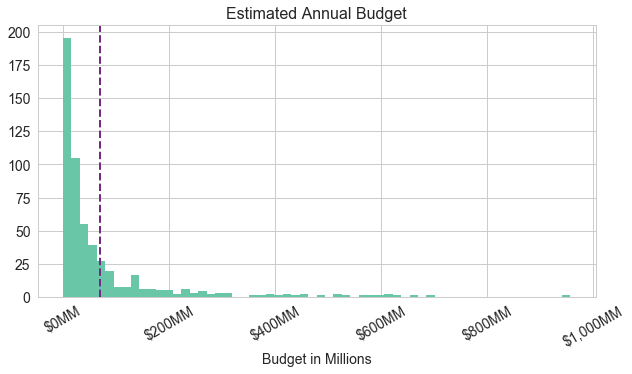

In [385]:
#Exclude budgets of over one billion dollars. 
bjs_sub_nooutliers = bjs_sub[bjs_sub['BDGT_TTL']<=1000000000.00]
pd.options.display.float_format = '${:,.0f}'.format
budget_mils = bjs_sub_nooutliers['BDGT_TTL'].apply(lambda x: x / 1000000)

#Plot a histogram of the budgets.
plt.figure(figsize=(10, 5))
ax = budget_mils.plot(kind='hist', bins=60, fontsize=14, color='#69c7a8')
fmt = '${x:,.0f}MM'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.set_title('Estimated Annual Budget', fontsize=16)
plt.axvline(budget_mils.mean(), color='#762a83', linestyle='dashed', linewidth=2)
plt.ylabel('')
plt.xlabel('Budget in Millions', fontsize=14)
plt.xticks(rotation=30)
plt.show()

## **2. Products in the Sales Pipeline**

The second question in this report concerns the progress of Occam Video Solutions products through the sales pipeline. Occam tracks sales of iNPUT-ACE software licenses, support, renewals, and training across four stages: "Prospecting", "Quote", "Committeed", and "Closed Won". We would like to know the answers to the following questions:

- What proportion of sales opportunities is at each stage of the process?
- How are sales opportunities and revenue distributed across product types? 
- How quickly do sales of different products progress through the pipeline, from prospecting to final sale?
- Has Occam Video Solutions been successful so far in ensuring that customers purchase training together with the software license, and vice versa?

### *Overview of current sales opportunities*

There are 1295 sales opportunities documented in the iNPUT-ACE SalesForce records. The current picture is an optimistic one, as 46.6% of sales opportunities have been closed since the company's incorporation approximately two years ago, while only 11% were lost. Opportunities at the quote stage account for 37.7% of the sales pipeline. 

1295


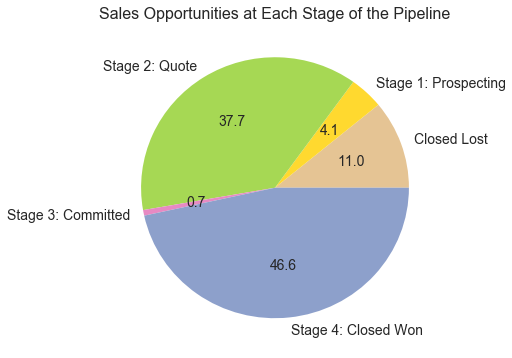

In [383]:
print(len(opportunities))

#Plot the proportion of opportunities at each stage.
order = ['Closed Lost', 'Stage 1: Prospecting', 'Stage 2: Quote', 'Stage 3: Committed', 'Stage 4: Closed Won']
stages = opportunities['Stage'].value_counts()

with sns.color_palette("Set2_r", 6):
    opportunities['Stage'].value_counts().loc[order].plot(kind='pie', autopct='%.1f', figsize=(6, 6), fontsize=14)
    pylab.ylabel('')
    plt.title('Sales Opportunities at Each Stage of the Pipeline', fontsize=16)

The smaller number of opportunities at the prospecting stage suggest that sales may slow as the company ages; however, this inference may not be warranted if we look at the nature of the products in the sales pipeline. Occam Video Solutions depends not only on the one-time sale of new iNPUT-ACE software license, but also on the sale of companion software, training, support, and renewals of support packages. Let us examine how sales opportunities and revenue are distributed among the different products.

First, we must acknowledge a gap in the data: 76% of sales are handled by Occam, while 24% are handled by a reseller. The reseller does not currently provide Occam Video Solutions with complete information about each sale. Thus, for the purposes of this report, complete data are available only for Occam's direct sales. 

Proceeding with an analysis of direct sales only, we find that software licenses, including companion licenses, account for the largest share of the sales opportunities, followed by training, while support sales and renewals account for much smaller shares.

In [301]:
#Check how many sales are handled by the reseller, identified by a string 'Ocean' in the 'Opportunity Name' field.
pd.options.display.float_format = '{:,.1f}'.format
opportunities['reseller'] = 'Direct Sale'
opportunities.loc[(opportunities['Opportunity Name'].str.contains('Ocean')), ['reseller']] = 'Reseller'

ocean_percent = opportunities.groupby('reseller').sum()['Total Price'].transform(lambda x: x/sum(x) *100)
ocean_percent.sort_values(inplace=True, ascending=True)
print(ocean_percent)


reseller
Reseller      23.5
Direct Sale   76.5
Name: Total Price, dtype: float64


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


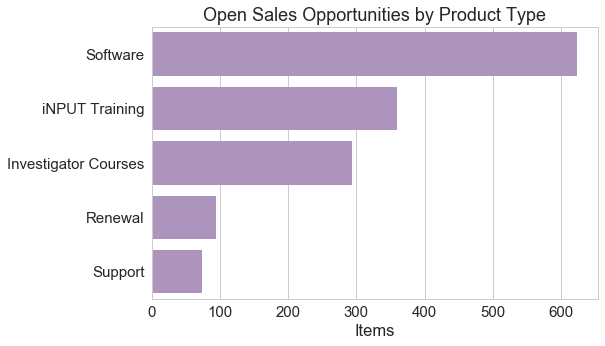

In [331]:
#Take the subset of opportunities that are still open.
open_opp = opportunities[opportunities['Stage']!='Closed Lost'] 
#quant_by_type=open_opp.groupby('Product Family').sum()['Quantity'].sort_values(ascending=False) 

#Count how many items per product type are in open opportunities.
grouped=open_opp.groupby('Product Family')
open_opp['quant_by_type']=grouped['Quantity'].transform('sum')
open_opp.sort_values(by='quant_by_type', ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
ax=sns.barplot(x='quant_by_type', y="Product Family", data=open_opp, color="#af8dc3")
ax.set(xlabel='Items', ylabel='', title='Open Sales Opportunities by Product Type')

#ax = quant_by_type.plot.barh(fontsize=14)
#ax.set_title('Open Sales Opportunities by Product Type', fontsize=16)
#plt.ylabel('Total Price')
#plt.ylabel('')
#plt.xlabel('')
#plt.show()

Software license sales are also responsible for the bulk of Occam Video Solutions' actual and potential revenue, as illustrated by the figure below. Given how new the product is, and how much of the law enforcement market in the United States remains untapped, as evidenced by the sample of agencies in the Bureau of Justice Statistics Survey, Occam Video Solutions may continue to depend on new sales for some time, until its customer base is large enough that it can subsist on support, renewals, and training. 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([       0.,   200000.,   400000.,   600000.,   800000.,  1000000.,
         1200000.,  1400000.,  1600000.]),
 <a list of 9 Text xticklabel objects>)

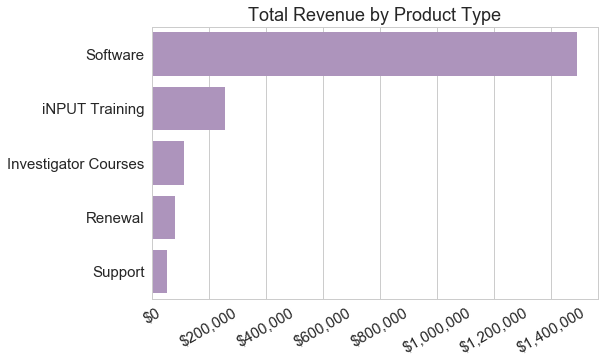

In [352]:
grouped=open_opp.groupby('Product Family')
open_opp['total_by_type']=grouped['Total Price'].transform('sum')
open_opp.sort_values(by='total_by_type', ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
ax=sns.barplot(x='total_by_type', y="Product Family", data=open_opp, color="#af8dc3")
ax.set(xlabel='', ylabel='', title='Total Revenue by Product Type')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
plt.xticks(rotation=30)

#quant_by_type=open_opp.groupby('Product Family').sum()['Total Price'].sort_values(ascending=False) 
#ax1 = quant_by_type.plot.barh(fontsize=14)
#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax1.xaxis.set_major_formatter(tick) 
#ax1.set_title('Total Revenue by Product Type', fontsize=16)
#plt.xticks(rotation=30)
#plt.ylabel('Total Price')
#plt.ylabel('')
#plt.xlabel('')
#plt.show()

This perspective is perhaps corroborated by the fact that over half of new software sales opportunities have yet to close. 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


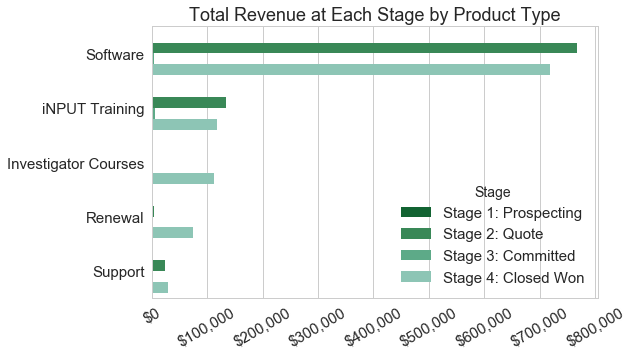

In [372]:
#Aggregate the data by product family and stage, and calculate the total revenue for each cell.

groupbyproductstage = open_opp.groupby(['Product Family', 'Stage'])
#print groupbyproductstage['Total Price'].aggregate(np.sum)
#groupbyproductstagesum = groupbyproductstage['Total Price'].aggregate(np.sum).unstack()
#print groupbyproductstagesum

open_opp['rev']=groupbyproductstage['Total Price'].transform('sum')

#Plot a grouped bar chart.

order=['Stage 1: Prospecting', 'Stage 2: Quote', 'Stage 3: Committed', 'Stage 4: Closed Won']
with sns.color_palette("BuGn_r"):
    plt.figure(figsize=(8, 5))
    sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
    ax1=sns.barplot(x='rev', y="Product Family", hue='Stage', data=open_opp, hue_order=order, )
    ax1.set(xlabel='', ylabel='', title='Total Revenue at Each Stage by Product Type')
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax1.xaxis.set_major_formatter(tick) 
    plt.xticks(rotation=30)

#plt.figure(figsize=(8, 5))
#ax = groupbyproductstagesum.plot(kind = 'bar', fontsize=14)
#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.yaxis.set_major_formatter(tick) 
#plt.xticks(rotation=30)
#ax.set_title('Total Revenue at Each Stage by Product Type', fontsize=16)
#plt.ylabel('Total Price', fontsize=14)
#plt.xlabel('')
#plt.show()

### *Sales from January 2016 - August 2017*

Now that we have surveyed the makeup of the sales pipeline, we would like to know more about the pace of sales. Let's take a look at sales of software--the main source of revenue--by month. There is a generally positive trend in the progress of sales opportunities since 2016, as illustrated by the figure below. (Note that sales for August and September of 2017 may actually be higher than reported.) 

Quotes and sales in 2017 tended to be highest in February, May, and August, suggesting that purchasing choices may be influenced by the customers' fiscal quarters. 

In [386]:
#Code date variables and create a new variable to remove future closing dates.

#strategy 1:
#for date in range(len(open_opp['Close Date'])):
#    if open_opp['Close Date'][date] == '12/31/2017':
#        open_opp['Close Date'][date] = 'NaN'

#strategy 2:
#open_opp.loc[(open_opp['Close Date'].str.contains('12/31/2017')), ['Close Date']] = 'NaN'

#strategy 3:
#open_opp['Past Close'] = open_opp['Close Date'].apply(lambda x: np.nan if x > '09/08/2017' else x)

today = datetime.date.today()
today = pd.to_datetime(today)

open_opp['Created Date'] = pd.to_datetime(open_opp['Created Date'])
open_opp['Close Date'] = pd.to_datetime(open_opp['Close Date'])
open_opp['Past Close'] = open_opp['Close Date'].apply(lambda x: np.nan if x > today else x)
open_opp['Past Close'] = pd.to_datetime(open_opp['Past Close'])



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

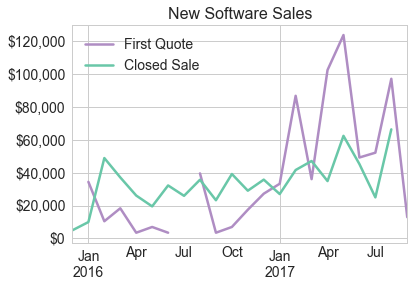

In [412]:
pd.options.display.float_format = '{:,.0f}'.format

software = open_opp[open_opp['Product Family']=='Software']
software = software[['Stage', 'Created Date', 'Close Date', 'Past Close', 'Total Price', 'Product Name']]

purchase_patterns2 = software[['Total Price','Created Date', 'Stage']]
purchase_patterns2 = software[software['Stage']=='Stage 2: Quote']
purchase_patterns2 = purchase_patterns2.set_index('Created Date')
#quotes = purchase_patterns2.resample('M').apply(sum) 

purchase_patterns4 = software[['Total Price', 'Past Close', 'Stage']]
purchase_patterns4 = software[software['Stage']=='Stage 4: Closed Won']
purchase_patterns4 = purchase_patterns4.set_index('Past Close')
#finals = purchase_patterns4.resample('M').apply(sum) 

plt.figure(figsize=(8, 5))

ax = purchase_patterns2.resample('M').apply(sum).plot(color='#af8dc3', fontsize=14)
purchase_patterns4.resample('M').apply(sum).plot(ax=ax, color='#69c7a8')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.legend(labels=['First Quote','Closed Sale'], fontsize=14)
ax.set_title('New Software Sales', fontsize=16)
plt.xlabel('')
plt.show()

### *Progress of sales through the pipeline*

The purple line tracking quotes in the figure above shows how much potential revenue is accounted for by software license quotes, but in order to predict when this revenue might be received, it would be useful to know how long customers typically take to make a purchase decision. To evaluate this, let us consider the time from first quote to final sale by product type. 

In [413]:
#Create a new timedelta variable to track how many days elapse between the opportunity's creation and closing.
#Map any null or negative values to NaN.

open_opp['Difference'] = open_opp['Past Close'] - open_opp['Created Date']
open_opp['Difference'] = open_opp['Difference'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
open_opp['Difference'] = open_opp['Difference'].apply(lambda x: np.nan if x<0 else x)
closed_customers = open_opp[open_opp['Stage'] == 'Stage 4: Closed Won']
closed_customers = closed_customers[closed_customers['Past Close'] != 'NaN']
closed_customers.groupby('Product Family')['Difference'].describe()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,count,mean,std,min,25%,50%,75%,max
Product Family,,,,,,,,
Investigator Courses,63,19,21,0,4,13,25,99
Renewal,60,47,48,0,8,28,71,211
Software,235,118,136,0,20,63,170,555
Support,38,120,131,0,24,71,170,516
iNPUT Training,112,92,124,0,6,39,133,555


Customers take on average 118 days to purchase software after receiving an initial quote. Sales of support packages are generally coupled with software sales, so it is not surprising that the average time to purchase of support, 120 days, is similar. Renewals of support packages and companion licenses tend to move more quickly through the pipeline, with an average time to purchase of just 47 days. 

By visualizing the distributions of the time to purchase of the different product types in a boxplot, we can see that software, iNPUT training, and support have a similar pace through the pipeline, which is expected, since they are designed to be sold together. 

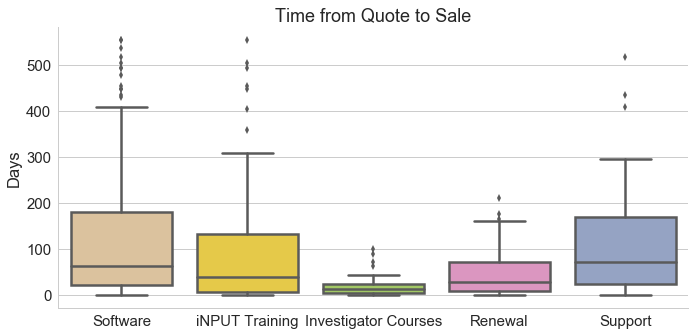

In [433]:

#open_opp['Difference'].plot(kind='box', by='Product Family', title='N', fontsize=14)

#open_opp.boxplot('Difference', by='Product Family', figsize=(12, 8), fontsize=14)
#plt.title('Time from Quote to Sale', fontsize=16)
#plt.ylabel('Days', fontsize=14)
#plt.xlabel('')
#plt.suptitle('')

with sns.color_palette("Set2_r", 6):
    plt.figure(figsize=(8, 5))
    ax = sns.factorplot(x="Product Family", y="Difference", data=open_opp, size=5, aspect=2, kind='box')
    ax.set(xlabel='', ylabel='Days', title='Time from Quote to Sale')

#plt.show()

In [39]:
from scipy import stats

k = len(pd.unique(open_opp['Product Family']))  # number of conditions
N = len(open_opp.values)  # conditions times participants
n = open_opp.groupby('Product Family').size()[0] #Participants in each condition

DFbetween = k - 1
DFwithin = N - k
DFtotal = N - 1

SSbetween = (sum(open_opp.groupby('Product Family').sum()['Difference']**2)/n) - (open_opp['Difference'].sum()**2)/N
    
#sum_y_squared = sum([x**2 for x in open_opp['Difference'].values])

open_opp['ysquared'] = open_opp['Difference']**2

sum_y_squared = open_opp['ysquared'].sum()

SSwithin = sum_y_squared - sum(open_opp.groupby('Product Family').sum()['Difference']**2)/n

SStotal = sum_y_squared - (open_opp['Difference'].sum()**2)/N

MSbetween = SSbetween/DFbetween

MSwithin = SSwithin/DFwithin

F = MSbetween/MSwithin

p = stats.f.sf(F, DFbetween, DFwithin)

eta_sqrd = SSbetween/SStotal

om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)

#print(sum_y_squared)
print('DF between groups={}'.format(DFbetween))
print('DF within groups={}'.format(DFwithin))
print('F={}'.format(F))
print('p={}'.format(p))
print('eta squared={}'.format(eta_sqrd))
print('omega squared={}'.format(om_sqrd))

#mod = ols('Difference ~ Product Family', open_opp=open_opp).fit()             
#aov_table = sm.stats.anova_lm(mod, typ=2)
#print aov_table

DF between groups=5
DF within groups=1147
F=337.849073145
p=1.54819821662e-222
eta squared=0.595592111366
omega squared=0.593619919543


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


There is a statistically significant difference between the time from quote to product sale for the different product types as determined by one-way ANOVA (F(4,1147) = 337.85, p < 0.001, eta-squared=0.6). In future research, it would be valuable to use a post-hoc Tukey test to determine precisely which product types differ significantly from the others with respect to time to purchase. 

### *Customers needing training, and trained customers needing software*

The data surveyed above suggest that customers make decisions to purchase iNPUT-ACE software and iNPUT-ACE hands-on training at roughly the same pace. This does not yet tell us, however, whether all the customers who purchase software also purchase training, and vice versa. Occam Video Solutions would like all customers to receive training, so that they can leverage iNPUT-ACE's full functionality. Likewise, customers who receive training will ideally be so impressed with the product's functionality that they will purchase a license. 

Let's check how many current customers still need either training or a license.

NOTE: The cell below does not yet do what I want it to do! I tried many different approaches.

Pseudocode:

For each agency in the needs.groupby('Agency Name'), check whether the column 'Product Family' contains 'Software'; if yes, assign 'True' to the column 'has_software'.

In [529]:
#Initialize new columns tracking the ones that need training vs. the ones that need license...

needs=open_opp[['Past Close', 'Agency Name', 'Stage', 'Product Family', 'Product Name']]
needs=needs[needs['Stage']=='Stage 4: Closed Won']
needs['need']='None'

needs_grouped=needs.groupby('Agency Name')

needs['has_software']=False
needs['has_training']=False
needs['has_webinar']=False

for agency in needs['Agency Name']:
    if any(needs['Product Family'].isin(['Software'])):
        needs['has_software']=True

for agency in needs['Agency Name']:
    if any(needs['Product Family'].isin(['iNPUT Training'])):
        needs['has_training']=True

print(needs['has_training'].describe())
print(needs['has_software'].describe())

count      603
unique       1
top       True
freq       603
Name: has_training, dtype: object
count      603
unique       1
top       True
freq       603
Name: has_software, dtype: object


### *Overview of training campaigns*

Occam Video Solutions analysts offer several different types of training courses, which have been attended by 1,971 individuals. iNPUT-ACE software is featured in all of the training campaigns. While the Investigators Two Day training serves to market iNPUT-ACE software, the iNPUT-ACE Two Day training is designed for customers who have purchased a license, as discussed above. To date, Occam Video Solutions analysts have delivered 18 Investigators Two Day training workshops and 13 iNPUT-ACE Two Day training workshops.

Total attendees: 1971


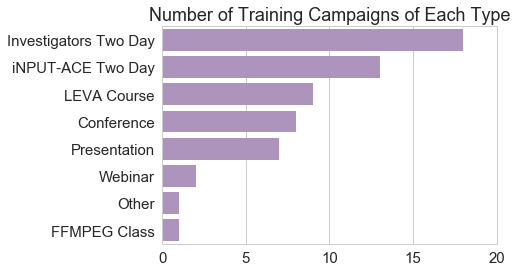

In [530]:
#How many campaigns by type
tot_attendees = len(campaigns)
print('Total attendees: {}'.format(tot_attendees))

#groupbycampaigncounts = campaigns.groupby('Campaign Type')['Campaign Name'].nunique().sort_values(ascending=True) 
#groupbycampaigncounts.plot.barh(fontsize=14, title='Number of Training Campaigns of Each Type')
#plt.xticks([0,5,10,15,20])
#plt.ylabel('')
#plt.ylabel('')
#plt.xlabel('')
#plt.show()

campaigns['counts'] = campaigns.groupby('Campaign Type')['Campaign Name'].transform('nunique')
order = ['Investigators Two Day', 'iNPUT-ACE Two Day', 'LEVA Course', 'Conference', 'Presentation', 'Webinar', 'Other', 'FFMPEG Class']
ax = sns.barplot(y='Campaign Type', x='counts', data=campaigns, order=order, color="#af8dc3")
ax.set(xlabel='', ylabel='', xticks=[0, 5, 10, 15, 20], title='Number of Training Campaigns of Each Type')

Now that we know how many training campaigns of each type are offered, it would be useful to get a sense for how well attended each of these campaigns is. It is important to investigate training attendance, especially for the Investigators Two Day training and the Webinars, since these serve to market iNPUT-ACE software. Let's take a look at how many people attend each campaign.

The figure below shows that the campaigns types differ with respect to the size of the audience at each event. Investigators Two Day trainings range in attendance from very few attendees (3) to 53, since they cater to investigators at departments of various sizes. The iNPUT-ACE Two Day trainings are all quite intimate (maximum 17 attendees) due to their specialized nature, while the Webinars are available to a much larger audience, albeit less frequently. Given their large size, it may be useful for Occam to begin offering Webinars more frequently, to reach a broader market.

                       count  mean  std  min  25%  50%  75%  max
Campaign Type                                                   
Conference               338   100   66    4   47   52  166  166
FFMPEG Class              26    26    0   26   26   26   26   26
Investigators Two Day    307    27   16    3   12   27   40   53
LEVA Course              238    38   18    2   26   30   63   63
Other                     10    10    0   10   10   10   10   10
Presentation             429   253  109    1   87  317  317  317
Webinar                  481   298  103  123  123  358  358  358
iNPUT-ACE Two Day        142    12    3    4    9   12   14   17


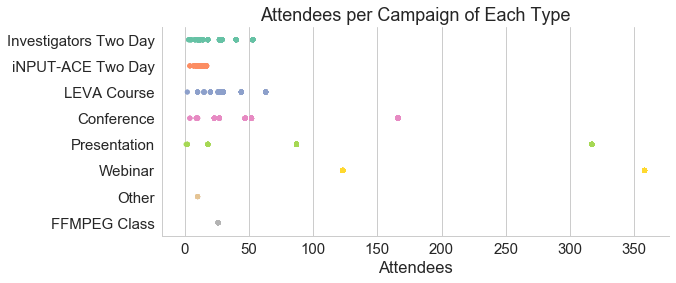

In [540]:
# How well attended are different types of training?

campaigns['attendees'] = campaigns.groupby('Campaign Name')['Campaign Name'].transform('count')
order = ['Investigators Two Day', 'iNPUT-ACE Two Day', 'LEVA Course', 'Conference', 'Presentation', 'Webinar', 'Other', 'FFMPEG Class']

with sns.color_palette("Set2", 8):
    ax = sns.factorplot(x='attendees', y='Campaign Type', order=order, data=campaigns, kind="strip", size=4, aspect=2.5)
    ax.set(ylabel='', xlabel='Attendees', title='Attendees per Campaign of Each Type')

print(campaigns.groupby('Campaign Type')['attendees'].describe())

Now that we have summarized the characteristics of the customer base and the makeup and pace of the sales pipeline, we will turn to an analysis of the factors that may predict purchasing behavior. 

## **3. Factors Associated With Purchasing Behavior**


### *Attendance at training campaigns*

In the previous section, we examined how long customers typically take to make a purchase decision after receiving an initial quote. Now, we will ask a similar question: how long do they typically take after attending a training campaign (setting aside iNPUT-ACE hands-on training and Webinars, which are specifically designed for those who already have a license) to purchase a license. 

Once we take an overview of the data, we can use an ANOVA to examine whether some types of training lead to faster purchasing decisions than others. 

In [555]:
#Of agencies attending training campaigns and presentations, how many also purchase software/final training?

campaigns2 = pd.merge(campaigns, open_opp, on='Agency ID', how='inner')
#campaigns2 = bjs_sub.set_index('AGENCY ID').join(open_opp.set_index('Agency ID'))
campaigns2 = campaigns2[campaigns2['Campaign Type']!='iNPUT-ACE Two Day']
campaigns2 = campaigns2[campaigns2['Campaign Type']!='Other']
campaigns2 = campaigns2[campaigns2['Product Family']=='Software']

In [560]:
#Create a variable to track how long after campaign attendance the customer makes a purchase.

campaigns2['End Date'] = pd.to_datetime(campaigns2['End Date'])
campaigns2['Past Campaign'] = campaigns2['End Date'].apply(lambda x: np.nan if x > today else x)
campaigns2['Past Campaign'] = pd.to_datetime(campaigns2['Past Campaign'])

campaigns2['Difference1'] = campaigns2['Past Close'] - campaigns2['Past Campaign']
campaigns2['Difference1'] = campaigns2['Difference1'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
campaigns2['Difference1'] = campaigns2['Difference1'].apply(lambda x: np.nan if x<0 else x)

closed_customers = campaigns2[campaigns2['Stage'] == 'Stage 4: Closed Won']
closed_customers = closed_customers[closed_customers['Past Close'] != 'NaN']

closed_customers.groupby('Campaign Type')['Difference1'].describe()

,count,mean,std,min,25%,50%,75%,max
Campaign Type,,,,,,,,
Conference,10,106,69,21,68,105,126,274
FFMPEG Class,18,203,156,39,74,144,397,414
Investigators Two Day,119,33,33,2,2,35,35,126
LEVA Course,90,485,269,5,339,468,660,"1,034"
Presentation,31,120,64,17,62,112,162,246
Webinar,17,93,67,1,54,54,135,253


Among the types of training campaigns, agencies whose personnel attend the Investigators Two Day training move forward fastest with the decision to purchase an iNPUT-ACE software license, with an average time to purchase of 33 days. The time to purchase from the different training types is depicted in the boxplot below. 

There is a statistically significant difference between the time from training to software purchase for the different training campaign types as determined by one-way ANOVA (F(5,1213) = 240.41, p < 0.001, eta-squared=0.5). 

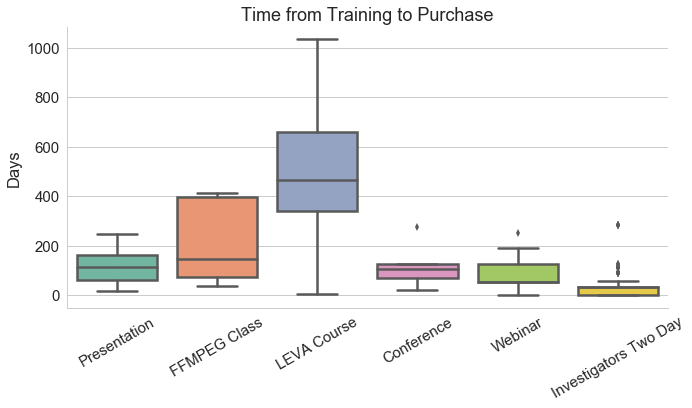

In [559]:
with sns.color_palette("Set2", 6):
    plt.figure(figsize=(8, 5))
    ax = sns.factorplot(x="Campaign Type", y="Difference1", data=campaigns2, size=5, aspect=2, kind='box')
    ax.set(xlabel='', ylabel='Days', title='Time from Training to Purchase')
    plt.xticks(rotation=30)

In [562]:
from scipy import stats

k = len(pd.unique(campaigns2['Campaign Type']))  # number of conditions
N = len(campaigns2.values)  # conditions times participants
n = campaigns2.groupby('Campaign Type').size()[0] #Participants in each condition

DFbetween = k - 1
DFwithin = N - k
DFtotal = N - 1

SSbetween = (sum(campaigns2.groupby('Campaign Type').sum()['Difference1']**2)/n) - (campaigns2['Difference1'].sum()**2)/N
    
#sum_y_squared = sum([x**2 for x in campaigns2['Difference'].values])

campaigns2['ysquared'] = campaigns2['Difference']**2

sum_y_squared = campaigns2['ysquared'].sum()

SSwithin = sum_y_squared - sum(campaigns2.groupby('Campaign Type').sum()['Difference1']**2)/n

SStotal = sum_y_squared - (campaigns2['Difference1'].sum()**2)/N

MSbetween = SSbetween/DFbetween

MSwithin = SSwithin/DFwithin

F = MSbetween/MSwithin

p = stats.f.sf(F, DFbetween, DFwithin)

eta_sqrd = SSbetween/SStotal

om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)

#print(sum_y_squared)
print('DF between groups={}'.format(DFbetween))
print('DF within groups={}'.format(DFwithin))
print('F={}'.format(F))
print('p={}'.format(p))
print('eta squared={}'.format(eta_sqrd))
print('omega squared={}'.format(om_sqrd))

#mod = ols('Difference ~ Product Family', campaigns2=campaigns2).fit()             
#aov_table = sm.stats.anova_lm(mod, typ=2)
#print aov_table

DF between groups=5
DF within groups=1213
F=240.414769721
p=1.63234808696e-178
eta squared=0.497737926026
omega squared=0.495462441802


### *Number of contacts*

Are agencies where Occam has a greater number of individual contacts more likely to purchase software? To answer this question fully, we would need to fit a logistic regression to classify each agency as a purchaser or non-purchaser. This is a matter for future research, but in the meantime, we can inspect the descriptive statistics for the variables in question in a table, and approach the difference between the two groups with a t-test instead. Occam has on average 4.2 contacts at agencies that purchase software (sd=4.48), and 2.9 contacts on agencies that do not (sd=3.61). This is not a large difference, but it is significant, according to an independent samples t-test (t=3.4, p<0.001).


In [626]:
pd.options.display.float_format = '{:,.2f}'.format

contacts2 = pd.merge(agencies, open_opp, on='Agency Name', how='inner')
#contacts2['purchased'] = False
contacts2['purchased'] = np.where((contacts2['Product Family']=='Software') & (contacts2['Stage']=='Stage 4: Closed Won'), True, False)
contacts2.sort_values(by='purchased', ascending=False, inplace=True)
contacts2.groupby('Agency Name')
contacts2 = contacts2.drop_duplicates(subset='Agency Name', keep="first")

#contacts2['ag_purchased'] = contacts2.groupby('Agency Name').apply(contacts2['purchased'].isin([True]), True, False)
purchase = contacts2[contacts2['purchased']==True]
no_purchase = contacts2[contacts2['purchased']==False]

print(contacts2.groupby('purchased')['Contacts per Agency'].describe())

ttest_ind(purchase['Contacts per Agency'], no_purchase['Contacts per Agency'])


           count  mean  std  min  25%  50%  75%   max
purchased                                            
False     317.00  2.94 3.61 1.00 1.00 2.00 3.00 43.00
True      175.00  4.20 4.48 1.00 2.00 3.00 5.00 41.00


Ttest_indResult(statistic=3.4040796771374886, pvalue=0.00071833127801935169)

### *Agency demographics and expenditures*

The next component of the analysis concerns how agency-related factors influence purchasing decisions. The plot below compares the average amount spent on Occam Video Solutions product by agencies serving each type of jurisdiction. While campus police agencies spend the most on average, they do not account for a large share of Occam's customer base. Interestingly, despite serving the largest jurisdictions, the military and federal agencies tend to spend the least on iNPUT-ACE products. 

AttributeError: 'FacetGrid' object has no attribute 'yaxis'

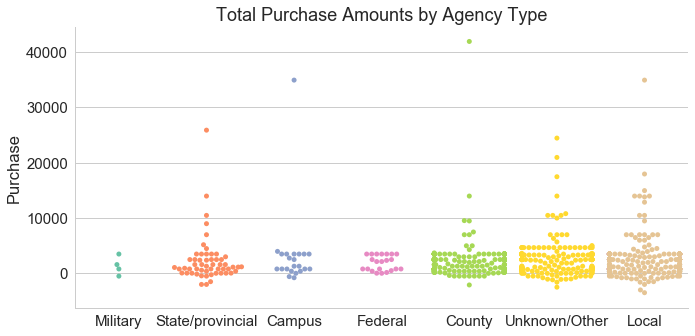

In [634]:
agencies1 = pd.merge(agencies, open_opp, on='Agency Name', how='inner')

with sns.color_palette("Set2", 8):
    plt.figure(figsize=(8, 5))
    ax = sns.factorplot(x="jurisdiction", y="Total Price", data=agencies1, size=5, aspect=2, kind='swarm')
    ax.set(xlabel='', ylabel='Purchase', title='Total Purchase Amounts by Agency Type')
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.xticks(rotation=30)
print(agencies1.groupby('jurisdiction')['Total Price'].describe())
    
#open_opp['Difference'].plot(kind='box', by='Product Family', title='N', fontsize=14)
#plt.show()

The question that readily follows from the last one is: do larger and better funded agencies purchase more Occam Video Solutions products than smaller ones? We can examine this with a bivariate correlation between spending amount and measures of agency size (peronnel) and funding (annual budget). There is a weak positive correlation between the two variables (r=0.34): better-funded agencies tend to spend a little bit more on Occam products.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                 spend_by_agency  BDGT_TTL  budget_mils
spend_by_agency             1.00      0.34         0.34
BDGT_TTL                    0.34      1.00         1.00
budget_mils                 0.34      1.00         1.00


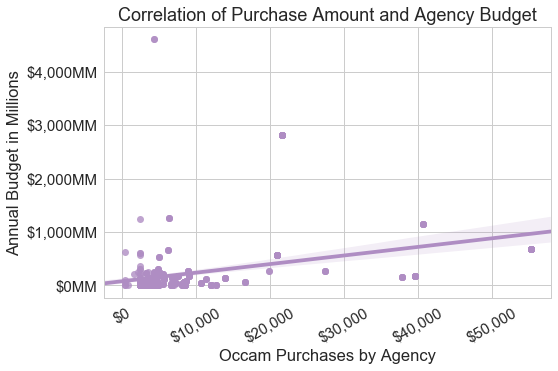

In [676]:
#Create a dataframe including opportunities and the agency-level BJS information.
agencies2 = bjs_sub.set_index('AGENCY ID').join(open_opp.set_index('Agency ID'))

#Compute the amount spent by agency.
agencies2['spend_by_agency']=open_opp.groupby('Agency ID').sum()['Total Price'].sort_values(ascending=False) 

to_corr = agencies2[['spend_by_agency','BDGT_TTL']]

to_corr['budget_mils'] = to_corr['BDGT_TTL'].apply(lambda x: x / 1000000)

#Plot the correlation in a scatterplot.
plt.figure(figsize=(8, 5))
ax = sns.regplot(x="spend_by_agency", y="budget_mils", data=to_corr, color="#af8dc3");
ax.set(xlabel='Occam Purchases by Agency', ylabel='Annual Budget in Millions', title='Correlation of Purchase Amount and Agency Budget')
fmt = '${x:,.0f}'
fmt1 = '${x:,.0f}MM'
tick = mtick.StrMethodFormatter(fmt)
tick1 = mtick.StrMethodFormatter(fmt1)
ax.yaxis.set_major_formatter(tick1) 
ax.xaxis.set_major_formatter(tick) 
plt.xticks(rotation=30)

#Run a bivariate correlation with spending by agency and budget total. 
print(to_corr.corr(method='pearson'))

#agencies2['FTSWORN'].corr(agencies2['spend_by_agency'])(method='pearson', min_periods=1)


Agency size could also be measured by the number of full-time officers it employs. There is in fact an extremely weak correlation between agency personnel size and spending on Occam products. This finding bodes well for Occam, as it seeks to expand its customer base in a market where the median agency size is just 161 full-time employees. Small agencies do not necessarily spend less on products and training for video analysis than large ones. 

                 spend_by_agency  FTSWORN
spend_by_agency             1.00     0.27
FTSWORN                     0.27     1.00


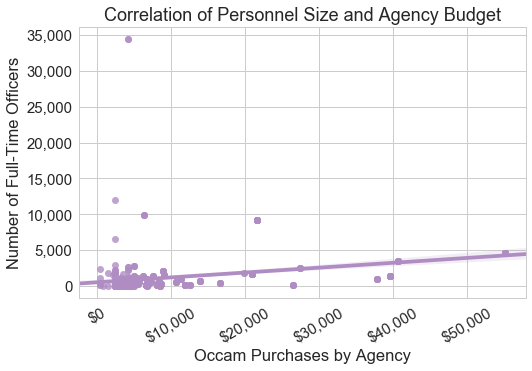

In [655]:
to_corr1 = agencies2[['spend_by_agency','FTSWORN']]

#Plot the correlation in a scatterplot.
plt.figure(figsize=(8, 5))
ax = sns.regplot(x="spend_by_agency", y="FTSWORN", data=to_corr1, color="#af8dc3")
ax.set(xlabel='Occam Purchases by Agency', ylabel='Number of Full-Time Officers', title='Correlation of Personnel Size and Agency Budget')
fmt = '${x:,.0f}'
fmt1 = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
tick1 = mtick.StrMethodFormatter(fmt1)
ax.xaxis.set_major_formatter(tick) 
ax.yaxis.set_major_formatter(tick1) 
plt.xticks(rotation=30)

#Run a bivariate correlation with spending by agency and budget total. 
print(to_corr1.corr(method='pearson'))

### *Agency engagement with video*

iNPUT ACE software is used to manage and process video evidence by professionals in a variety of different roles at customer agencies. While it is safe to say that all law enforcement agencies engage with video evidence, agencies differ in their capability and experience when it comes to handling video. For example, some agencies include a dedicated video unit with certified technicians and analysts, but many do not. Demand for iNPUT-ACE software might be greater in agencies with professionals who engage with video on a regular basis in high-stakes contexts, because these professionals have experience confronting the problems iNPUT-ACE is designed to solve. The marketing campaigns of Occam Video Solutions target such agencies by showcasing its products at conferences and workshops attended by forensic video technicians and analysts and offering a discount to members of the Law Enforcement Video Association (LEVA). 

The Bureau of Justice Statistics survey unfortunately does not ask respondents to indicate whether they employ certified video analysis professionals or whether they hold LEVA membership; however, it does include items addressing how agencies use video. Specifically, it asks whether they use video for surveillance of public spaces, patrol vehicles, patrol officers, weapons, and "other". The figure below plots the amount spent on Occam products per agency, by whether or not the agency uses video for surveillance of public spaces, patrol vehicles, and patrol officers. 

In future research, we could ask whether agencies that use video in these contexts are more likely to purchase iNPUT- ACE software than those who do not, using a chi-square test of independence. We can also examine whether agencies that use video tend to spend more on iNPUT-ACE products than those that do not, using a series of independent samples t-tests.

The descriptive summaries and boxplots below indicate that agencies that use video for public surveillance, police videos, and patrol officers spend more on Occam products on average.

NOTE: Unlike above, the t-test is not outputting any numerical results. The boxplots also need some fine-tuning to get the axis labels and colors right.

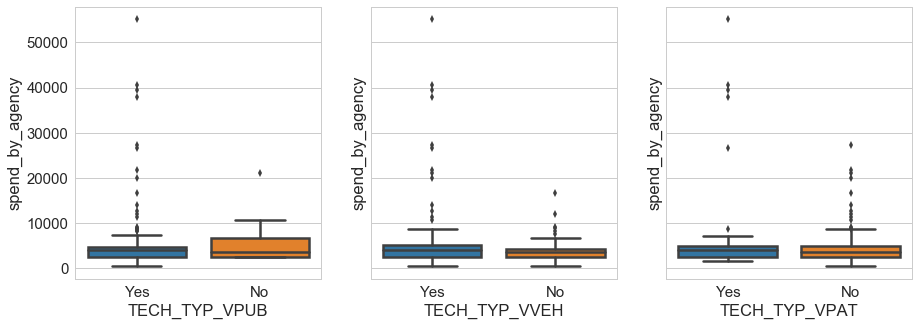

               count     mean      std      min      25%      50%      75%  \
TECH_TYP_VPUB                                                                
No             42.00 4,823.19 3,407.28 2,494.73 2,494.73 3,564.09 6,572.50   
Yes           157.00 5,561.73 7,368.78   395.00 2,494.73 3,890.00 4,727.40   

                    max  
TECH_TYP_VPUB            
No            20,986.39  
Yes           55,156.80  
Ttest_indResult(statistic=nan, pvalue=nan)
               count     mean      std    min      25%      50%      75%  \
TECH_TYP_VVEH                                                              
No             57.00 4,261.22 2,600.23 395.00 2,494.73 3,562.16 4,290.00   
Yes           142.00 5,865.32 7,755.77 395.00 2,494.73 3,890.00 5,059.31   

                    max  
TECH_TYP_VVEH            
No            16,588.20  
Yes           55,156.80  
Ttest_indResult(statistic=nan, pvalue=nan)
               count     mean       std      min      25%      50%      75%  \
TECH_TYP_

In [715]:

#bjs_sub['TECH_TYP_VVEH'].value_counts().plot(kind='barh', stacked=True, fontsize=14)


agencies2.sort_values(by='TECH_TYP_VPUB', ascending=False, inplace=True)
agencies2.groupby('Agency Name')
agenciespub = agencies2.drop_duplicates(subset='Agency Name', keep="first")

vpub = agenciespub[agenciespub['TECH_TYP_VPUB']=='Yes']
no_vpub = agenciespub[agenciespub['TECH_TYP_VPUB']=='No']

#ax = sns.factorplot(x="TECH_TYP_VPUB", y="spend_by_agency", data=agenciespub, kind="box")

agencies2.sort_values(by='TECH_TYP_VVEH', ascending=False, inplace=True)
agencies2.groupby('Agency Name')
agenciesveh = agencies2.drop_duplicates(subset='Agency Name', keep="first")

#contacts2['ag_purchased'] = contacts2.groupby('Agency Name').apply(contacts2['purchased'].isin([True]), True, False)
vveh = agenciesveh[agenciesveh['TECH_TYP_VVEH']=='Yes']
no_vveh = agenciesveh[agenciesveh['TECH_TYP_VVEH']=='No']

#ax1 = sns.factorplot(x="TECH_TYP_VVEH", y="spend_by_agency", data=agenciesveh, kind="box")


agencies2.sort_values(by='TECH_TYP_VPAT', ascending=False, inplace=True)
agencies2.groupby('Agency Name')
agenciespat = agencies2.drop_duplicates(subset='Agency Name', keep="first")

#contacts2['ag_purchased'] = contacts2.groupby('Agency Name').apply(contacts2['purchased'].isin([True]), True, False)
vpat = agenciespat[agenciespat['TECH_TYP_VPAT']=='Yes']
no_vpat = agenciespat[agenciespat['TECH_TYP_VPAT']=='No']

#ax2 = sns.factorplot(x="TECH_TYP_VPAT", y="spend_by_agency", data=agenciespat, kind="box")

#fig = plt.figure(figsize=(15, 5))
#ax1 = fig.add_subplot(131)
#ax2 = fig.add_subplot(132)
#ax3 = fig.add_subplot(133)

fig, axs = plt.subplots(ncols=3, figsize=(15,5), sharey='all')


ax = sns.factorplot(x="TECH_TYP_VPUB", y="spend_by_agency", data=agenciespub, kind="box", ax=axs[0])
sns.factorplot(x="TECH_TYP_VVEH", y="spend_by_agency", data=agenciesveh, kind="box", ax=axs[1])
sns.factorplot(x="TECH_TYP_VPAT", y="spend_by_agency", data=agenciespat, kind="box", ax=axs[2])
#ax.set(xlabel='', ylabel='test', title='Time from Quote to Sale')

#fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')

plt.close(2)
plt.close(3)
plt.close(4)

plt.show()


print(agenciespub.groupby('TECH_TYP_VPUB')['spend_by_agency'].describe())

print(ttest_ind(vpub['spend_by_agency'], no_vpub['spend_by_agency']))

print(agenciesveh.groupby('TECH_TYP_VVEH')['spend_by_agency'].describe())

print(ttest_ind(vveh['spend_by_agency'], no_vveh['spend_by_agency']))

print(agenciespat.groupby('TECH_TYP_VPAT')['spend_by_agency'].describe())

print(ttest_ind(vpat['spend_by_agency'], no_vpat['spend_by_agency']))
